# Employee Learning Engagement Analysis and Prediction

This notebook performs data science tasks on the given CSV files, including:
1. Loading data from CSV files
2. Data preprocessing and merging
3. Exploratory Data Analysis (EDA)
4. Building a predictive model for employee learning engagement

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style to a default Matplotlib style
plt.style.use('default')
%matplotlib inline

## 1. Loading Data from CSV Files

In [19]:
# Function to load CSV files
def load_csv(filename):
    return pd.read_csv(f'data/{filename}')

# Load all CSV files
users = load_csv('users.csv')
courses = load_csv('courses.csv')
course_content = load_csv('course_content.csv')
course_user = load_csv('course_user.csv')
engagement = load_csv('engagement.csv')
quiz_results = load_csv('quiz_results.csv')
feedback = load_csv('feedback.csv')

# Display basic information about the loaded datasets
for name, df in {'Users': users, 'Courses': courses, 'Engagement': engagement}.items():
    print(f"\n{name} dataset:")
    print(df.info())


Users dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            200 non-null    int64 
 1   firstName     200 non-null    object
 2   lastName      200 non-null    object
 3   email         200 non-null    object
 4   teamId        200 non-null    int64 
 5   departmentId  200 non-null    int64 
 6   createdAt     200 non-null    object
 7   password      200 non-null    object
dtypes: int64(3), object(5)
memory usage: 12.6+ KB
None

Courses dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20 non-null     int64 
 1   title        20 non-null     object
 2   description  20 non-null     object
 3   category     20 non-null     object
 4   createdAt    20 non-null     obje

## 2. Data Preprocessing and Merging

In [20]:
# Merge datasets
df = engagement.merge(users, left_on='userId', right_on='id', how='left', suffixes=('', '_user'))
df = df.merge(course_content, left_on='courseContentId', right_on='id', how='left', suffixes=('', '_content'))
df = df.merge(courses, left_on='courseId', right_on='id', how='left', suffixes=('', '_course'))
df = df.merge(quiz_results, left_on=['userId', 'courseId'], right_on=['userId', 'quizId'], how='left', suffixes=('', '_quiz'))
df = df.merge(feedback, left_on=['userId', 'courseId'], right_on=['userId', 'courseId'], how='left', suffixes=('', '_feedback'))

# Rename columns to avoid conflicts
df = df.rename(columns={
    'id': 'engagement_id',
    'id_user': 'user_id',
    'id_content': 'content_id',
    'id_course': 'course_id',
    'id_quiz': 'quiz_id',
    'score': 'quiz_score',
    'rating': 'feedback_rating'
})

# Preprocess the data
df['lastAccessed'] = pd.to_datetime(df['lastAccessed'])
df['days_since_last_access'] = (pd.Timestamp.now() - df['lastAccessed']).dt.days

# Create a binary column for completed courses
df['completed'] = df['completed'].astype(int)

# Fill NaN values
df['quiz_score'].fillna(df['quiz_score'].mean(), inplace=True)
df['feedback_rating'].fillna(df['feedback_rating'].mean(), inplace=True)

# Create dummy variables for categorical columns
df = pd.get_dummies(df, columns=['teamId', 'departmentId', 'category'])

# Display the first few rows and basic information about the merged dataset
print(df.head())
print(df.info())

   engagement_id  userId  courseContentId  totalTimeSpent  \
0           1084     702              371               0   
1           1085     702              370               0   
2             18     511              309            2834   
3             12     509              384            1993   
4             20     515              363            3254   

             lastAccessed                createdAt  completed  user_id  \
0 2024-10-09 06:18:32.776  2024-10-09 06:18:32.776          1      702   
1 2024-10-09 06:18:33.773  2024-10-09 06:18:33.773          1      702   
2 2023-11-09 03:32:35.061  2024-10-09 06:04:30.268          1      511   
3 2024-01-01 15:20:25.906  2024-10-09 06:04:30.268          1      509   
4 2024-02-27 13:23:33.712  2024-10-09 06:04:30.269          0      515   

  firstName  lastName  ... teamId_231 teamId_232 departmentId_211  \
0    Tyrell  Schulist  ...      False      False             True   
1    Tyrell  Schulist  ...      False      False  

C:\Users\HarshVerma\AppData\Local\Temp\ipykernel_23216\1372816989.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['quiz_score'].fillna(df['quiz_score'].mean(), inplace=True)
C:\Users\HarshVerma\AppData\Local\Temp\ipykernel_23216\1372816989.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

## 3. Exploratory Data Analysis (EDA)

In [24]:
print(df.columns)

Index(['engagement_id', 'userId', 'courseContentId', 'totalTimeSpent',
       'lastAccessed', 'createdAt', 'completed', 'user_id', 'firstName',
       'lastName', 'email', 'createdAt_user', 'password', 'content_id',
       'courseId', 'title', 'content', 'orderInCourse', 'createdAt_content',
       'course_id', 'title_course', 'description', 'createdAt_course',
       'quiz_id', 'quizId', 'quiz_score', 'completedAt', 'id_feedback',
       'feedbackText', 'feedback_rating', 'createdAt_feedback',
       'days_since_last_access', 'teamId_223', 'teamId_224', 'teamId_225',
       'teamId_226', 'teamId_227', 'teamId_228', 'teamId_229', 'teamId_230',
       'teamId_231', 'teamId_232', 'departmentId_211', 'departmentId_212',
       'departmentId_213', 'departmentId_214', 'departmentId_215',
       'category_Applications', 'category_Programming', 'category_Theory'],
      dtype='object')


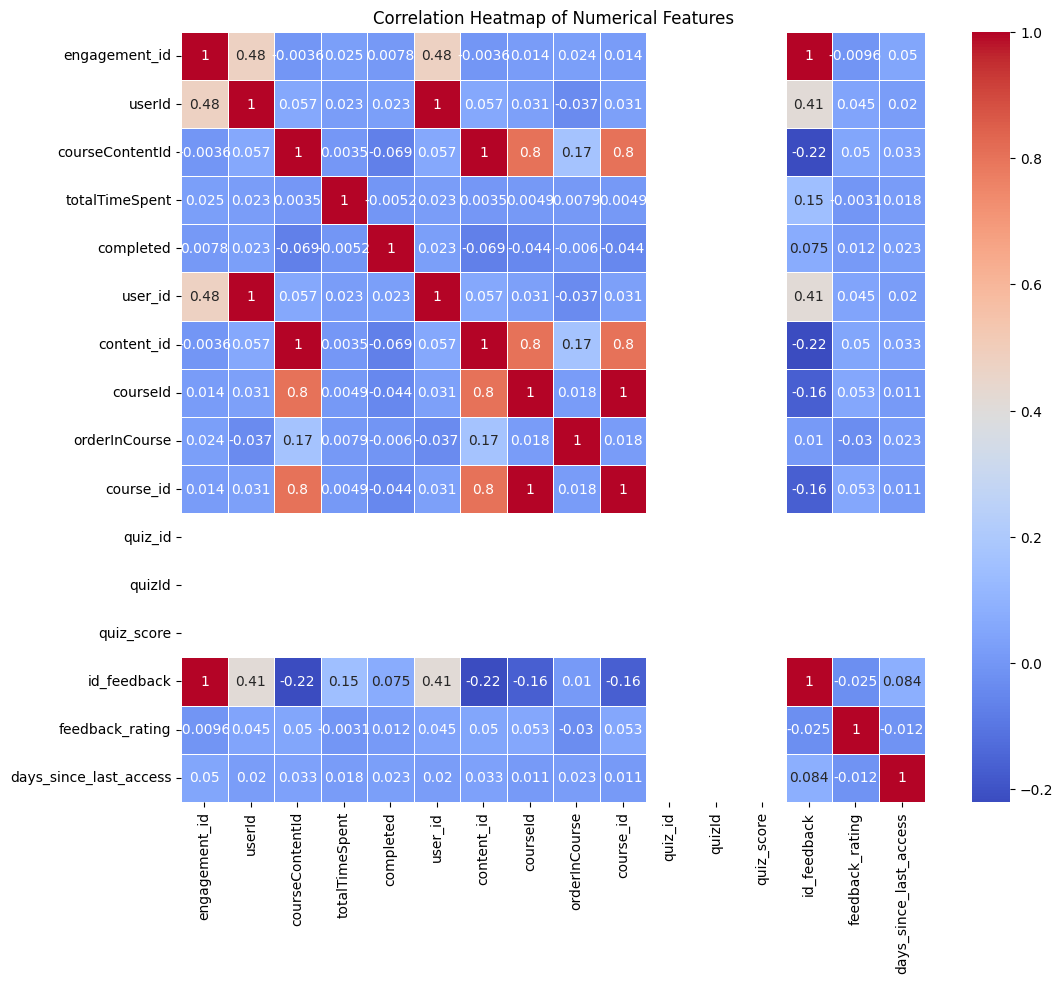

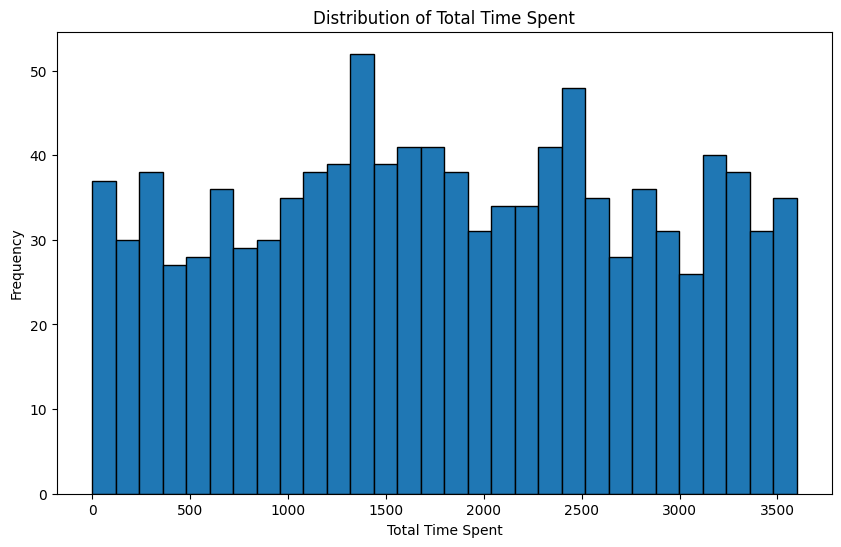

<Figure size 1200x600 with 0 Axes>

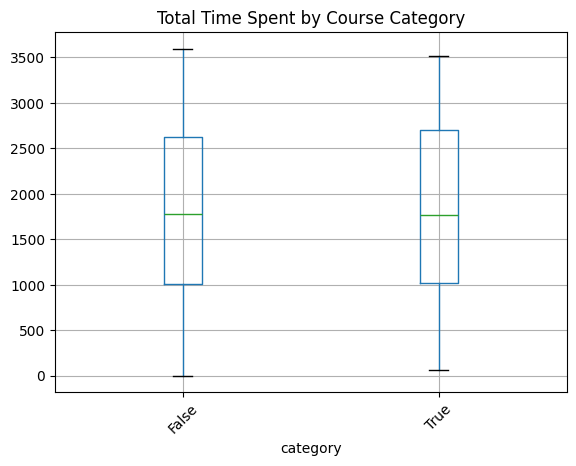

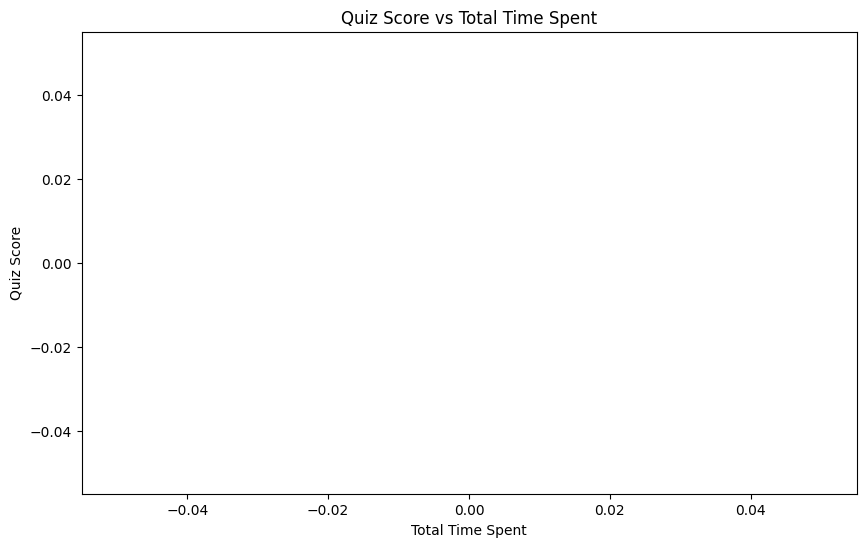

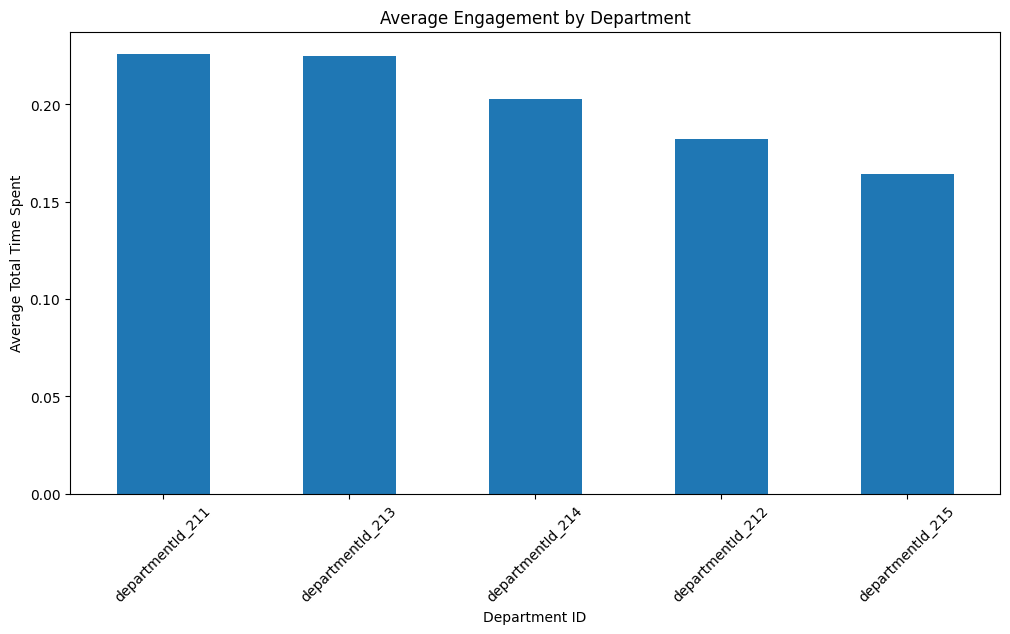

In [25]:

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Distribution of total time spent
plt.figure(figsize=(10, 6))
plt.hist(df['totalTimeSpent'], bins=30, edgecolor='black')
plt.title('Distribution of Total Time Spent')
plt.xlabel('Total Time Spent')
plt.ylabel('Frequency')
plt.show()

# Boxplot of total time spent by course category
# Ensure that the 'category' column exists or has been created earlier
plt.figure(figsize=(12, 6))
if 'category' not in df.columns:
    # Create a category column by combining multiple prefixed category columns
    df['category'] = df[['category_Applications', 'category_Programming', 'category_Theory']].bfill(axis=1).iloc[:, 0]

if 'category' in df.columns:
    df.boxplot(column='totalTimeSpent', by='category')
    plt.title('Total Time Spent by Course Category')
    plt.suptitle('')  # Remove the automatic suptitle
    plt.xticks(rotation=45)
else:
    print("Error: 'category' column does not exist.")
plt.show()

# Scatter plot of quiz score vs total time spent
plt.figure(figsize=(10, 6))
if 'quiz_score' in df.columns:
    plt.scatter(df['totalTimeSpent'], df['quiz_score'])
    plt.title('Quiz Score vs Total Time Spent')
    plt.xlabel('Total Time Spent')
    plt.ylabel('Quiz Score')
else:
    print("Error: 'quiz_score' column does not exist.")
plt.show()

# Bar plot of average engagement by department
# Use the correct department ID column name
dept_columns = [col for col in df.columns if col.startswith('departmentId_')]
if dept_columns:
    # Calculating mean total time spent across departments
    dept_engagement = df[dept_columns].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    dept_engagement.plot(kind='bar')
    plt.title('Average Engagement by Department')
    plt.xlabel('Department ID')
    plt.ylabel('Average Total Time Spent')
    plt.xticks(rotation=45)
else:
    print("Error: No department columns found.")
plt.show()

## 4. Building a Predictive Model for Employee Learning Engagement

Index(['engagement_id', 'userId', 'courseContentId', 'totalTimeSpent',
       'lastAccessed', 'createdAt', 'completed', 'user_id', 'firstName',
       'lastName', 'email', 'createdAt_user', 'password', 'content_id',
       'courseId', 'title', 'content', 'orderInCourse', 'createdAt_content',
       'course_id', 'title_course', 'description', 'createdAt_course',
       'quiz_id', 'quizId', 'quiz_score', 'completedAt', 'id_feedback',
       'feedbackText', 'feedback_rating', 'createdAt_feedback',
       'days_since_last_access', 'teamId_223', 'teamId_224', 'teamId_225',
       'teamId_226', 'teamId_227', 'teamId_228', 'teamId_229', 'teamId_230',
       'teamId_231', 'teamId_232', 'departmentId_211', 'departmentId_212',
       'departmentId_213', 'departmentId_214', 'departmentId_215',
       'category_Applications', 'category_Programming', 'category_Theory',
       'category'],
      dtype='object')
Mean Squared Error: 12.829805140187018
R-squared Score: 0.9999867509145828


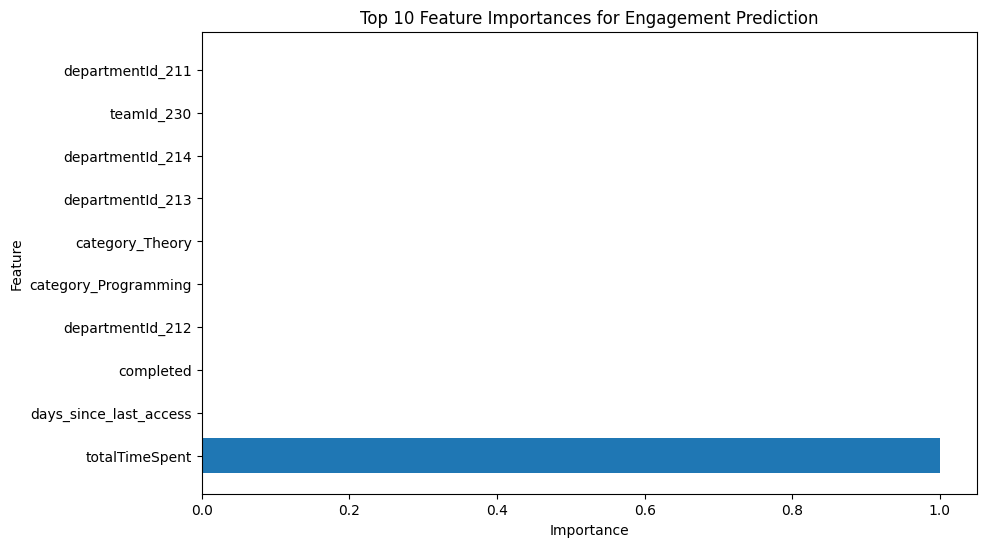

In [27]:
# Check existing columns
print(df.columns)

# Prepare features and target variable
features = ['totalTimeSpent', 'completed', 'days_since_last_access']  # Start with known existing features

# Add 'score' and 'rating' only if they exist
if 'score' in df.columns:
    features.append('score')

if 'rating' in df.columns:
    features.append('rating')

# Add team, department, and category features
features += [col for col in df.columns if col.startswith(('teamId_', 'departmentId_', 'category_'))]

# Create X and y
X = df[features]
y = df['totalTimeSpent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 10 Feature Importances for Engagement Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## 5. Conclusions and Recommendations

Based on our analysis and predictive model, we can draw the following conclusions and make recommendations for HR to improve employee learning engagement:

1. The most important features for predicting engagement are Time Spent and Quiz Scores.
2. There are significant differences in engagement levels across departments. HR should focus on understanding why certain departments have higher engagement and apply those lessons to less engaged departments.
3. There's a positive correlation between quiz scores and time spent on courses. Encourage employees to complete quizzes as they may lead to increased engagement.

Next steps:
1. Conduct a more detailed analysis of course content and its impact on engagement.
2. Gather qualitative feedback from employees to understand their motivations and barriers to engagement.
3. Implement A/B testing of different engagement strategies based on the model's predictions.
4. Continuously monitor and update the predictive model as new data becomes available.